In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, skew
from scipy.stats import zscore
from sklearn.cluster import KMeans




In [2]:
# Load the datasets using the specified paths
job_posting = pd.read_csv('./Raw_Data/postings.csv')
companies = pd.read_csv('./Raw_Data/companies/companies.csv')
job_skills = pd.read_csv('./Raw_Data/jobs/job_skills.csv')
mapping_skills = pd.read_csv('./Raw_Data/mappings/skills.csv')

In [3]:
# Companies dataset
companies = companies.astype({
    'company_id': 'Int64',
    'name': 'string',
    'company_size': 'float'
})

# Job postings dataset
job_posting = job_posting.astype({
    'job_id': 'Int64',
    'company_name': 'string',
    'min_salary': 'float'
})

# Job skills dataset
job_skills = job_skills.astype({
    'job_id': 'Int64',
    'skill_abr': 'string'
})

# Mapping skills dataset
mapping_skills = mapping_skills.astype({
    'skill_abr': 'string',
    'skill_name': 'string'
})

In [4]:
# Check for missing values in each DataFrame
missing_values_companies = companies.isnull().sum()
missing_values_job_skills = job_skills.isnull().sum()
missing_values_skills = mapping_skills.isnull().sum()
missing_values_postings = job_posting.isnull().sum()

In [5]:
# Display summaries of missing values after handling for verification
print("Missing values in companies:\n", missing_values_companies)
print("\nMissing values in job_skills:\n", missing_values_job_skills)
print("\nMissing values in mapping_skills:\n", missing_values_skills)
print("\nMissing values in job_posting:\n", missing_values_postings)


Missing values in companies:
 company_id         0
name               1
description      297
company_size    2774
state             22
country            0
city               1
zip_code          28
address           22
url                0
dtype: int64

Missing values in job_skills:
 job_id       0
skill_abr    0
dtype: int64

Missing values in mapping_skills:
 skill_abr     0
skill_name    0
dtype: int64

Missing values in job_posting:
 job_id                             0
company_name                    1719
title                              0
description                        7
max_salary                     94056
pay_period                     87776
location                           0
company_id                      1717
views                           1689
med_salary                    117569
min_salary                     94056
formatted_work_type                0
applies                       100529
original_listed_time               0
remote_allowed                108603
job

In [6]:
# Merge job_skills with mapping_skills to include full skill names
job_skills_detailed = job_skills.merge(mapping_skills, on="skill_abr", how="left")
# Display the first few rows of the merged data for verification
job_skills_detailed.head()

,job_id,skill_abr,skill_name
0,3884428798,MRKT,Marketing
1,3884428798,PR,Public Relations
2,3884428798,WRT,Writing/Editing
3,3887473071,SALE,Sales
4,3887465684,FIN,Finance


In [7]:
# Fill missing values in the companies DataFrame
fill_values = {
    'company_size': companies['company_size'].median(),
    'description': "No description provided",
    'state': "Unknown",
    'city': "Unknown",
    'zip_code': "Unknown",
    'address': "Unknown"
}

for column, value in fill_values.items():
    companies[column] = companies[column].fillna(value)

job_posting.fillna({'company_name': 'Unknown'})
job_posting.fillna({'description': 'No description provided'})


# Drop rows in job_posting where 'company_id' is missing
job_posting.dropna(subset=['company_id'], inplace=True)

# Convert 'company_id' to nullable integer to avoid float conversion
job_posting['company_id'] = job_posting['company_id'].astype('Int64')


In [8]:
# Print initial missing values in postings
print("Initial missing values in postings:\n", job_posting.isnull().sum())



Initial missing values in postings:
 job_id                             0
company_name                       2
title                              0
description                        6
max_salary                     92793
pay_period                     86568
location                           0
company_id                         0
views                           1627
med_salary                    115907
min_salary                     92793
formatted_work_type                0
applies                        99236
original_listed_time               0
remote_allowed                107318
job_posting_url                    0
application_url                35063
application_type                   0
expiry                             0
closed_time                   121076
formatted_experience_level     27949
skills_desc                   119696
listed_time                        0
posting_domain                 38252
sponsored                          0
work_type                          0
c

In [9]:
# # Calculate median salary values for filling
# salary_median = job_posting[['max_salary', 'min_salary']].median()
# job_posting['max_salary'] = job_posting['max_salary'].fillna(salary_median['max_salary'])
# job_posting['min_salary'] = job_posting['min_salary'].fillna(salary_median['min_salary'])

# Drop columns with too many missing values (over 80% missing)
columns_to_drop = ['med_salary', 'skills_desc', 'remote_allowed', 'closed_time','zip_code', 'fips', 'job_posting_url', 'application_url']
job_posting = job_posting.drop(columns=columns_to_drop, errors='ignore')


In [10]:
# Integration Step
job_data_combined = job_posting.merge(job_skills_detailed, on="job_id", how="left")
job_data_combined['company_id'] = job_data_combined['company_id'].astype('Int64')  # Ensure alignment with companies

# Now merge job_data_combined with companies on 'company_id' to include company information
full_data = job_data_combined.merge(companies, on="company_id", how="left")

# Check final missing values in full_data
print("Final missing values in full_data:\n", full_data.isnull().sum())


Final missing values in full_data:
 job_id                             0
company_name                       4
title                              0
description_x                     11
max_salary                    154686
pay_period                    144438
location                           0
company_id                         0
views                           2802
min_salary                    154686
formatted_work_type                0
applies                       165087
original_listed_time               0
application_type                   0
expiry                             0
formatted_experience_level     45677
listed_time                        0
posting_domain                 66789
sponsored                          0
work_type                          0
currency                      144438
compensation_type             144438
normalized_salary             144438
skill_abr                       1541
skill_name                      1541
name                               4
de

In [11]:
# Aggregation examples
job_count_per_company = full_data.groupby("company_id")['job_id'].count().reset_index()
job_count_per_company.rename(columns={"job_id": "total_jobs"}, inplace=True)
job_count_per_company = job_count_per_company.merge(companies[['company_id', 'name']], on='company_id', how='left')

print("Total job postings per company:\n", job_count_per_company[['name', 'total_jobs']].head())


Total job postings per company:
                          name  total_jobs
0                         IBM          33
1               GE HealthCare          85
2  Hewlett Packard Enterprise          24
3                      Oracle         127
4                   Accenture          37


In [12]:
skill_count = job_skills_detailed['skill_name'].value_counts().reset_index()
skill_count.columns = ['skill_name', 'count']
print("Top required skills across all jobs:\n", skill_count.head())

Top required skills across all jobs:
                skill_name  count
0  Information Technology  26137
1                   Sales  22475
2              Management  20861
3           Manufacturing  18185
4    Health Care Provider  17369


In [13]:
# Drop duplicates
full_data.drop_duplicates(inplace=True)

In [14]:
# Final sampling step
sampled_data = full_data.sample(frac=0.05, random_state=42).copy()
print("\nSample of fully processed data:\n", sampled_data.head())


Sample of fully processed data:
             job_id                                   company_name  \
179699  3905351309                           Signature HealthCARE   
20013   3887593646                           Keck Medicine of USC   
23240   3887872935                                        Netflix   
151463  3904577325  TMAC's Direct Hire (Executive Search) Service   
131876  3903840980                             FirstChoice Hiring   

                                                    title  \
179699                  Certified Nursing Assistant (CNA)   
20013   Licensed Vocational Nurse - Emergency Room - F...   
23240   Technical Program Manager 6 - Game SDK and Ser...   
151463     Field Medical Director, Pediatric Gene Editing   
131876       HVAC Technicians / Installers - Capital Heat   

                                            description_x  max_salary  \
179699  About Us\n\nWelcome to Signature Healthcare of...         NaN   
20013   The Licensed Vocational Nurse 

In [15]:
# First, create the salary range and category if not already created
job_posting['salary_range'] = job_posting['max_salary'] - job_posting['min_salary']
job_posting['salary_range_category'] = pd.cut(job_posting['salary_range'], bins=[0, 20000, 50000, 100000], labels=['Low', 'Medium', 'High'])

# Select and print company name, salary details, and the salary range category
print(job_posting[['company_name', 'min_salary', 'max_salary', 'salary_range_category']].head())


                company_name  min_salary  max_salary salary_range_category
0      Corcoran Sawyer Smith        17.0        20.0                   Low
2     The National Exemplar      45000.0     65000.0                   Low
3     Abrams Fensterman, LLP    140000.0    175000.0                Medium
5  Downtown Raleigh Alliance        14.0        20.0                   Low
6                 Raw Cereal     60000.0    300000.0                   NaN


In [16]:

# Assuming 'listed_time' is in milliseconds, convert it to datetime
job_posting['original_listed_time'] = pd.to_datetime(job_posting['original_listed_time'], unit='ms')


# Function to categorize seasons based on month
def get_season(date):
    if date.month in [12, 1, 2]:  # December to February
        return 'Winter'
    elif date.month in [3, 4, 5]:  # March to May
        return 'Spring'
    elif date.month in [6, 7, 8]:  # June to August
        return 'Summer'
    else:  # September to November
        return 'Fall'

# Apply the function to create a new column 'season'
job_posting['season'] = job_posting['original_listed_time'].apply(get_season)

# Display random entries with styled output
random_sample = job_posting[['original_listed_time', 'season']].sample(n=10, random_state=1).style.set_table_attributes('style="width: 50%; margin: auto;"').set_caption("Random Job Postings with Original Listed Time and Season")

# Render the styled output
random_sample


,original_listed_time,season
46016,2024-04-17 22:26:32,Spring
88336,2024-04-17 23:02:56,Spring
71548,2024-04-19 00:00:00,Spring
101909,2024-04-18 19:44:54,Spring
31934,2024-04-11 16:59:46,Spring
119893,2024-04-19 21:29:14,Spring
80520,2024-04-18 00:00:00,Spring
16444,2024-04-05 00:00:00,Spring
23081,2024-04-09 12:39:56,Spring
24392,2024-04-11 17:56:35,Spring


In [17]:
# Define all seasons with initial count of zero
all_seasons = {"Winter": 0, "Spring": 0, "Summer": 0, "Fall": 0}

# Count occurrences of each season in the 'expiry' column
season_counts = job_posting['season'].value_counts().to_dict()

# Update the all_seasons dictionary with actual counts
all_seasons.update(season_counts)

# Display the complete season counts including Winter
print("\nOriginal Listed Time  Date Counts by Season")
for season, count in all_seasons.items():
    print(f"{season}: {count}")


Original Listed Time  Date Counts by Season
Winter: 16
Spring: 122116
Summer: 0
Fall: 0


In [18]:
# Create the is_full_time column if not already created
job_posting['is_full_time'] = job_posting['work_type'].apply(lambda x: 1 if x == 'Full-Time' else 0)

# Select and print company name and the is_full_time indicator
print(job_posting[['company_name', 'is_full_time']].head())


                company_name  is_full_time
0      Corcoran Sawyer Smith             0
2     The National Exemplar              0
3     Abrams Fensterman, LLP             0
5  Downtown Raleigh Alliance             0
6                 Raw Cereal             0


In [19]:
# Zgjedhja e veçorive numerike për PCA
features = job_posting[['max_salary', 'min_salary', 'views', 'applies']]

# Imputimi i vlerave të humbura
imputer = SimpleImputer(strategy='median')
features_imputed = imputer.fit_transform(features)

# Normalizimi i të dhënave
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Aplikimi i PCA
pca = PCA(n_components=2)  # Zgjedhja e dy përbërësve
principal_components = pca.fit_transform(features_scaled)

# Krijimi i DataFrame për përbërësit
pca_df = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])

# Shtimi i kolonave origjinale për identifikim
pca_df['job_id'] = job_posting['job_id']
pca_df['company_name'] = job_posting['company_name']

# Shfaqja e rezultatit
print(pca_df)

            PCA1      PCA2      job_id                      company_name
0      -0.346517 -0.085717      921716             Corcoran Sawyer Smith
1      -0.084540 -0.130993        <NA>                              <NA>
2       0.414807 -0.067497    10998357            The National Exemplar 
3      -0.346875 -0.066296    23221523            Abrams Fensterman, LLP
4       0.438256 -0.252185        <NA>                              <NA>
...          ...       ...         ...                               ...
122127  0.397005 -0.191231  3906251986                 BAE Systems, Inc.
122128 -0.010333 -0.172640  3906251989                 BAE Systems, Inc.
122129 -0.010333 -0.172640  3906251990                 BAE Systems, Inc.
122130 -0.010273 -0.164386  3906251999                      Job Juncture
122131  0.007687 -0.180980  3906252016  K&A Engineering Consulting, P.C.

[122132 rows x 4 columns]


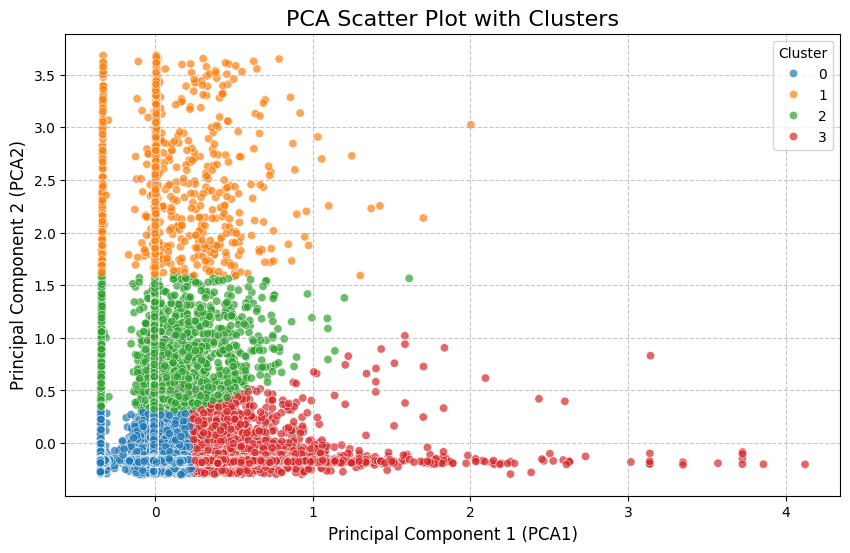

In [20]:
# Vizualizimii Pca ne clastuers

# Step 1: Calculate z-scores for PCA1 and PCA2
pca_df['PCA1_zscore'] = zscore(pca_df['PCA1'])
pca_df['PCA2_zscore'] = zscore(pca_df['PCA2'])

# Step 2: Remove outliers (z-score threshold: |z| > 3)
pca_cleaned = pca_df[(pca_df['PCA1_zscore'].abs() <= 3) & (pca_df['PCA2_zscore'].abs() <= 3)]


# Ensure pca_cleaned is an independent DataFrame
pca_cleaned = pca_cleaned.copy()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
pca_cleaned['Cluster'] = kmeans.fit_predict(pca_cleaned[['PCA1', 'PCA2']])

# Scatter plot with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', data=pca_cleaned, hue='Cluster', palette='tab10', alpha=0.7)
plt.title('PCA Scatter Plot with Clusters', fontsize=16)
plt.xlabel('Principal Component 1 (PCA1)', fontsize=12)
plt.ylabel('Principal Component 2 (PCA2)', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
 

In [21]:
# Create a new folder named 'processed_data' (you can choose any name)
folder_name = 'Processed_data'
os.makedirs(folder_name, exist_ok=True)  # Creates the folder if it doesn't exist
# Save the preprocessed data to a new CSV file in the created folder
job_posting.to_csv(os.path.join(folder_name, 'preprocessed_job_postings.csv'), index=False)
companies.to_csv(os.path.join(folder_name, 'companies.csv'), index=False)
job_skills.to_csv(os.path.join(folder_name, 'job_skills.csv'), index=False)
mapping_skills.to_csv(os.path.join(folder_name, 'mapping_skills.csv'), index=False)


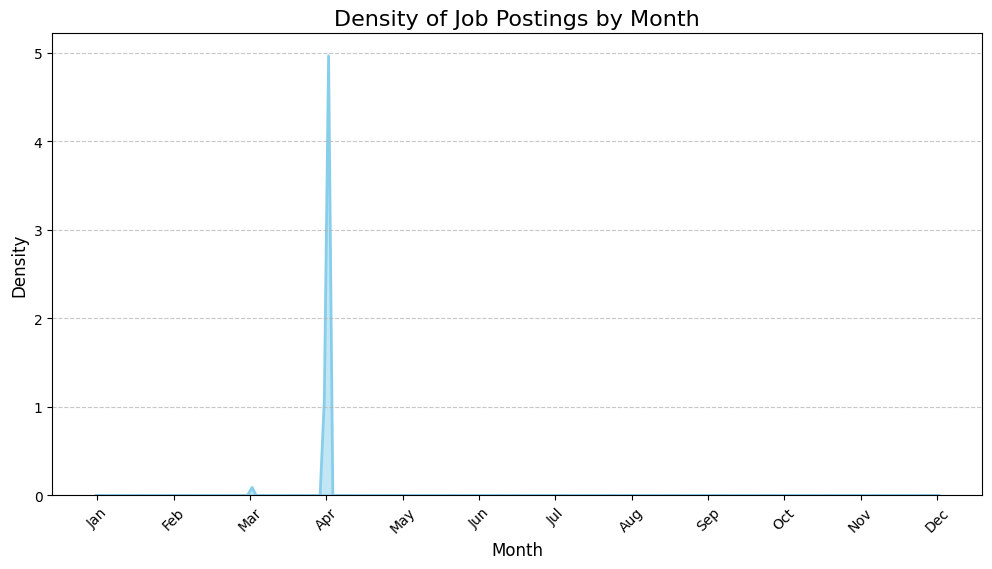

In [22]:


# Ensure 'original_listed_time' is in datetime format
job_posting['original_listed_time'] = pd.to_datetime(job_posting['original_listed_time'], unit='ms')

# Extract the month from 'original_listed_time'
job_posting['month'] = job_posting['original_listed_time'].dt.month

# Plot the density of job postings by month
plt.figure(figsize=(12, 6))
sns.kdeplot(data=job_posting, x='month', fill=True, alpha=0.5, linewidth=2, color='skyblue')
plt.title('Density of Job Postings by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




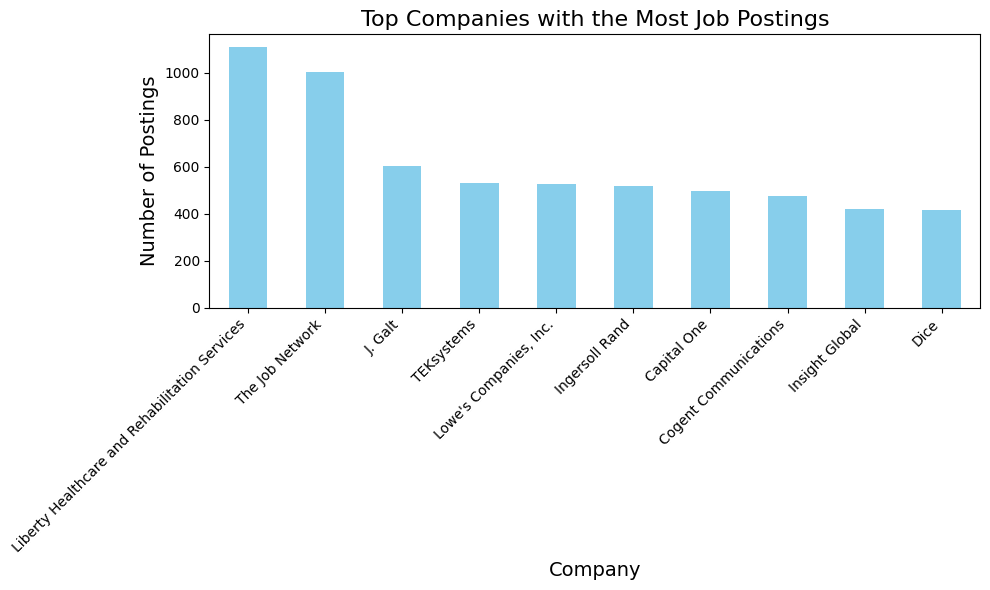

In [24]:
# 1. Histogram for companies with the most job postings
company_counts = job_posting['company_name'].value_counts()

plt.figure(figsize=(10, 6))
company_counts.head(10).plot(kind='bar', color='skyblue')
plt.title('Top Companies with the Most Job Postings', fontsize=16)
plt.xlabel('Company', fontsize=14)
plt.ylabel('Number of Postings', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




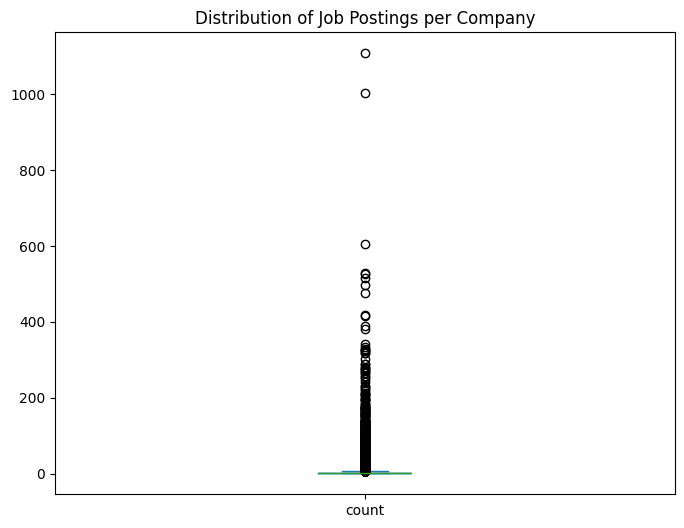

In [25]:
job_count_per_company = job_posting['company_name'].value_counts()
job_count_per_company.plot(kind='box', figsize=(8, 6), title="Distribution of Job Postings per Company")
plt.show()

In [26]:

# Calculate job counts per company
job_count_per_company = job_posting['company_name'].value_counts()

# Convert to DataFrame for easier handling
job_count_df = pd.DataFrame({'company_name': job_count_per_company.index, 'job_count': job_count_per_company.values})

# Ensure 'job_count' is numeric and handle any non-numeric or NaN issues
job_count_df['job_count'] = pd.to_numeric(job_count_df['job_count'], errors='coerce')

# Drop rows with NaN values in 'job_count'
job_count_df.dropna(subset=['job_count'], inplace=True)

# Ensure 'job_count' is of type int or float
job_count_df['job_count'] = job_count_df['job_count'].astype(float)

# Calculate Z-Score for the job counts
job_count_df['zscore'] = zscore(job_count_df['job_count'])

# Filter out outliers using Z-Score threshold
zscore_threshold = 3
job_count_cleaned = job_count_df[job_count_df['zscore'].abs() <= zscore_threshold]['job_count']






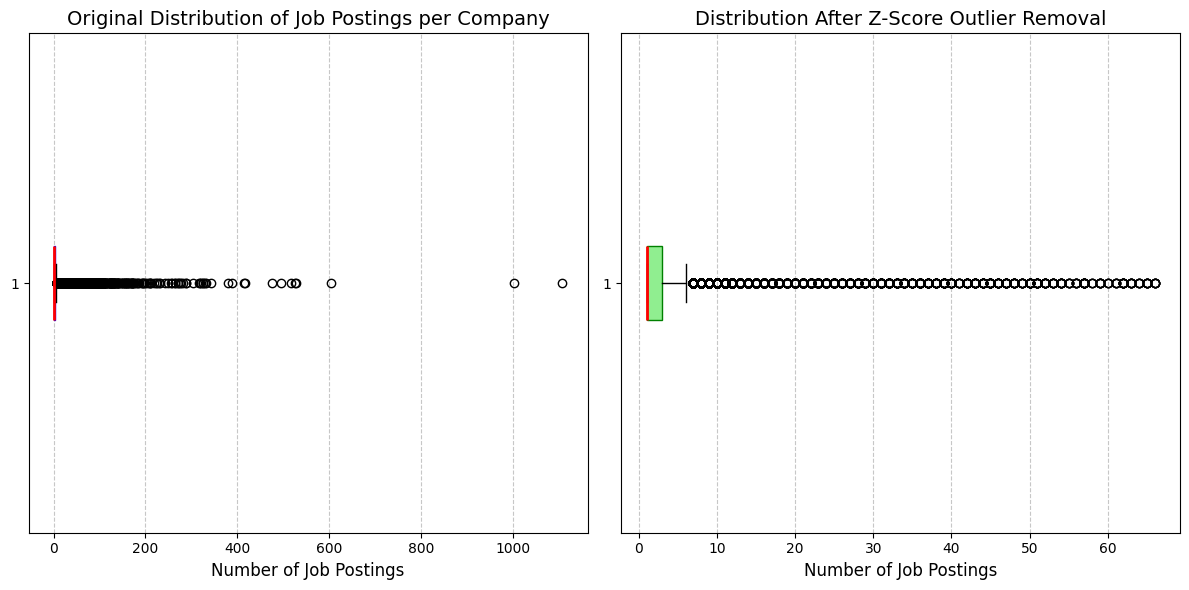

In [27]:
plt.figure(figsize=(12, 6))

# Original Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(job_count_per_company, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2))
plt.title("Original Distribution of Job Postings per Company", fontsize=14)
plt.xlabel("Number of Job Postings", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)

# Cleaned Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(job_count_cleaned, vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen', color='green'),
            medianprops=dict(color='red', linewidth=2))
plt.title("Distribution After Z-Score Outlier Removal", fontsize=14)
plt.xlabel("Number of Job Postings", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)

plt.tight_layout()
plt.show()


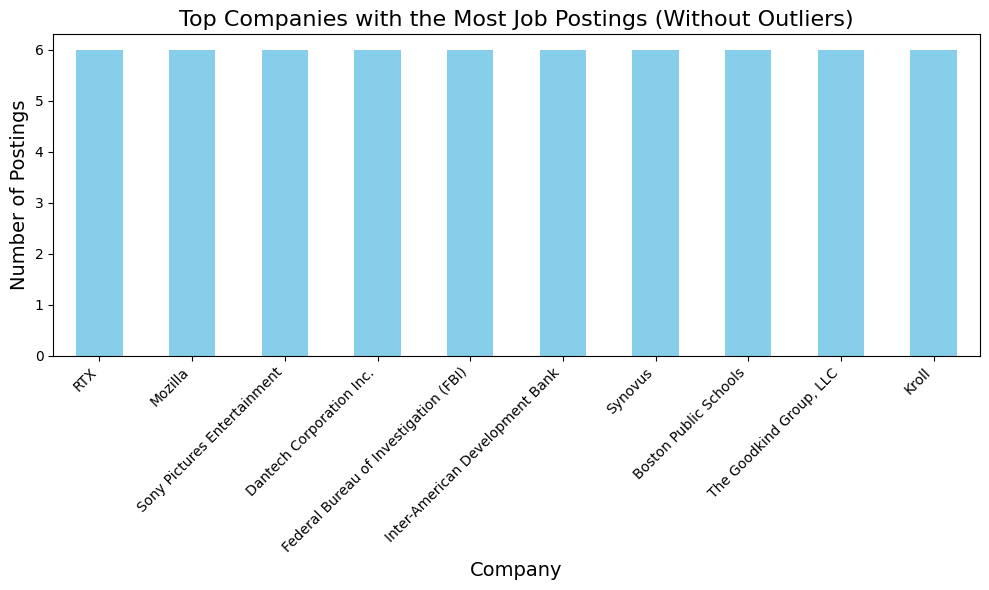

In [28]:
# 1. Remove outliers for company counts
company_counts = job_posting['company_name'].value_counts()

# Calculate IQR for company counts
Q1 = company_counts.quantile(0.25)
Q3 = company_counts.quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter data to remove outliers
filtered_company_counts = company_counts[(company_counts >= lower_bound) & (company_counts <= upper_bound)]

# Plot histogram for filtered companies
plt.figure(figsize=(10, 6))
filtered_company_counts.head(10).plot(kind='bar', color='skyblue')
plt.title('Top Companies with the Most Job Postings (Without Outliers)', fontsize=16)
plt.xlabel('Company', fontsize=14)
plt.ylabel('Number of Postings', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




Skill Frequencies:
   skill_abr  frequency
0        IT      26137
1      SALE      22475
2      MGMT      20861
3      MNFC      18185
4      HCPR      17369


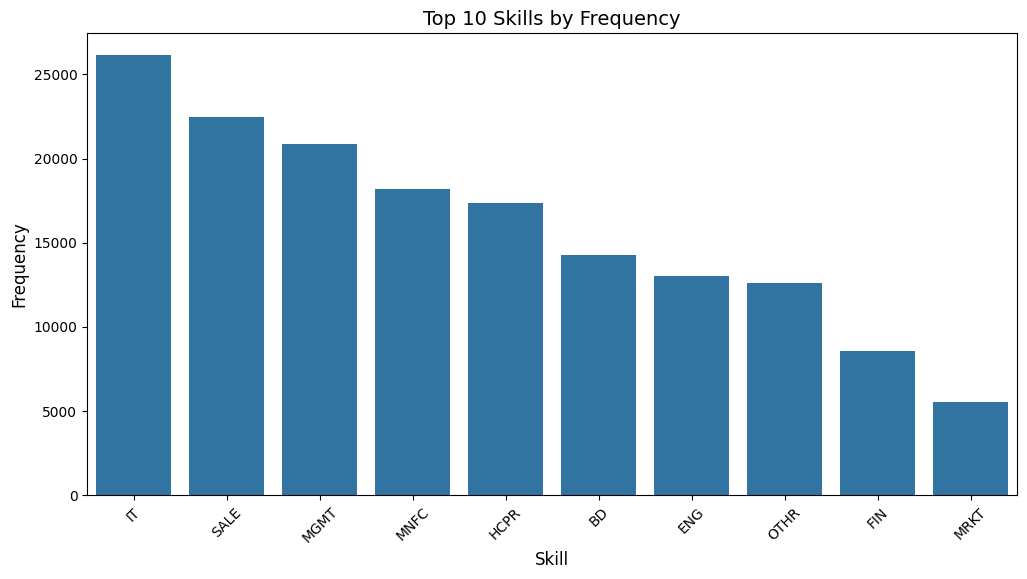

In [30]:

# Step 1: Prepare Data - Count job skills
skill_counts = job_skills['skill_abr'].value_counts().reset_index()
skill_counts.columns = ['skill_abr', 'frequency']
print("Skill Frequencies:\n", skill_counts.head())

# Step 2: Apply Z-Score for Outlier Detection
skill_counts['zscore'] = zscore(skill_counts['frequency'])
outliers = skill_counts[skill_counts['zscore'].abs() > 3]

# Step 3: Visualize Top 10 Skills by Frequency
top_skills = skill_counts.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='skill_abr', y='frequency', data=top_skills)
plt.title('Top 10 Skills by Frequency', fontsize=14)
plt.xlabel('Skill', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()

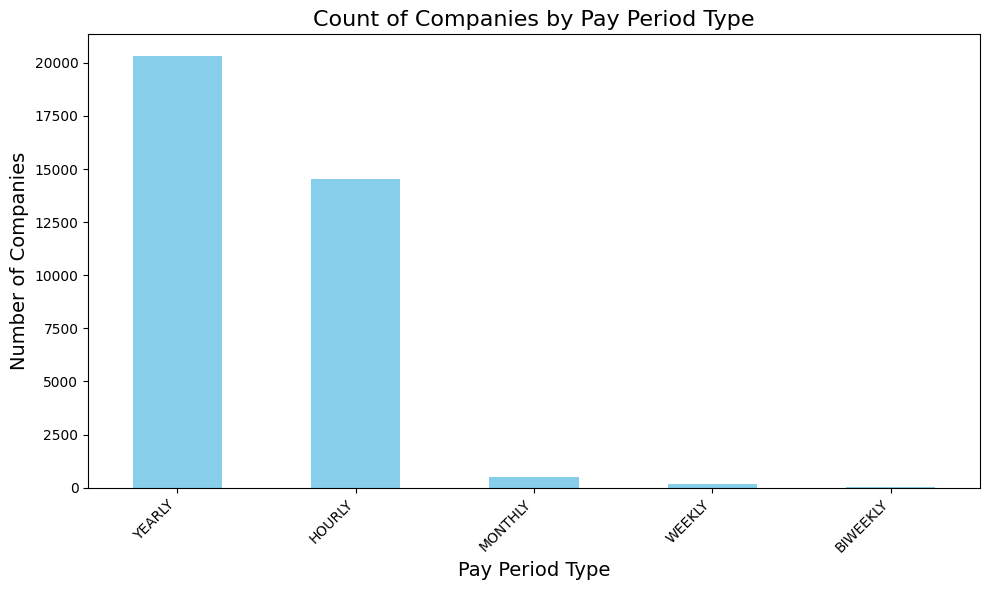

In [31]:
# Count how many companies have each pay period type
pay_period_counts = job_posting['pay_period'].value_counts()

# Plot the count of companies by pay period type
plt.figure(figsize=(10, 6))
pay_period_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Companies by Pay Period Type', fontsize=16)
plt.xlabel('Pay Period Type', fontsize=14)
plt.ylabel('Number of Companies', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [32]:

# Define conversion constants
HOURS_PER_MONTH = 160
HOURS_PER_YEAR = 2080

# Function to convert salaries to hourly
def convert_to_hourly(row):
    if row['pay_period'] == 'HOURLY':
        return row['min_salary'], row['max_salary']
    elif row['pay_period'] == 'MONTHLY':
        return row['min_salary'] / HOURS_PER_MONTH, row['max_salary'] / HOURS_PER_MONTH
    elif row['pay_period'] == 'YEARLY':
        return row['min_salary'] / HOURS_PER_YEAR, row['max_salary'] / HOURS_PER_YEAR
    else:
        return None, None  # Handle unexpected pay_period values

# Assuming 'job_posting' is the original dataframe containing the job posting data

# Drop rows with missing values in critical columns
job_posting_salaries = job_posting.dropna(subset=['max_salary', 'min_salary', 'pay_period'])

# Create a copy of the original DataFrame for safe modifications
job_posting_salaries = job_posting_salaries.copy()

# Normalize pay_period values and filter for valid ones
job_posting_salaries['pay_period'] = job_posting_salaries['pay_period'].str.upper()

# Drop rows where pay_period is not valid
job_posting_salaries = job_posting_salaries[job_posting_salaries['pay_period'].isin(['HOURLY', 'MONTHLY', 'YEARLY'])]

# Convert salaries to numeric and drop invalid rows
job_posting_salaries['min_salary'] = pd.to_numeric(job_posting_salaries['min_salary'], errors='coerce')
job_posting_salaries['max_salary'] = pd.to_numeric(job_posting_salaries['max_salary'], errors='coerce')
job_posting_salaries = job_posting_salaries.dropna(subset=['min_salary', 'max_salary'])

# Remove rows with negative or zero salaries
job_posting_salaries = job_posting_salaries[
    (job_posting_salaries['min_salary'] > 0) & (job_posting_salaries['max_salary'] > 0)
]

# Remove rows where min_salary is greater than max_salary
job_posting_salaries = job_posting_salaries[job_posting_salaries['min_salary'] <= job_posting_salaries['max_salary']]

# Remove extreme outliers (adjust bounds as needed)
job_posting_salaries = job_posting_salaries[
    (job_posting_salaries['min_salary'] >= 5) & (job_posting_salaries['max_salary'] <= 1_000_000)
]

# Remove duplicate rows
job_posting_salaries = job_posting_salaries.drop_duplicates()

# Create a copy for further processing
job_posting_salaries_copy = job_posting_salaries.copy()

# Apply the salary conversion function
job_posting_salaries_copy.loc[:, 'min_salary_hourly'], job_posting_salaries_copy.loc[:, 'max_salary_hourly'] = zip(
    *job_posting_salaries_copy.apply(lambda row: convert_to_hourly(row), axis=1)
)

# Display cleaned data
job_posting_salaries_copy[['min_salary', 'max_salary', 'pay_period', 'min_salary_hourly', 'max_salary_hourly']].head()


,min_salary,max_salary,pay_period,min_salary_hourly,max_salary_hourly
0,17.0,20.0,HOURLY,17.000000,20.000000
2,45000.0,65000.0,YEARLY,21.634615,31.250000
3,140000.0,175000.0,YEARLY,67.307692,84.134615
5,14.0,20.0,HOURLY,14.000000,20.000000
6,60000.0,300000.0,YEARLY,28.846154,144.230769


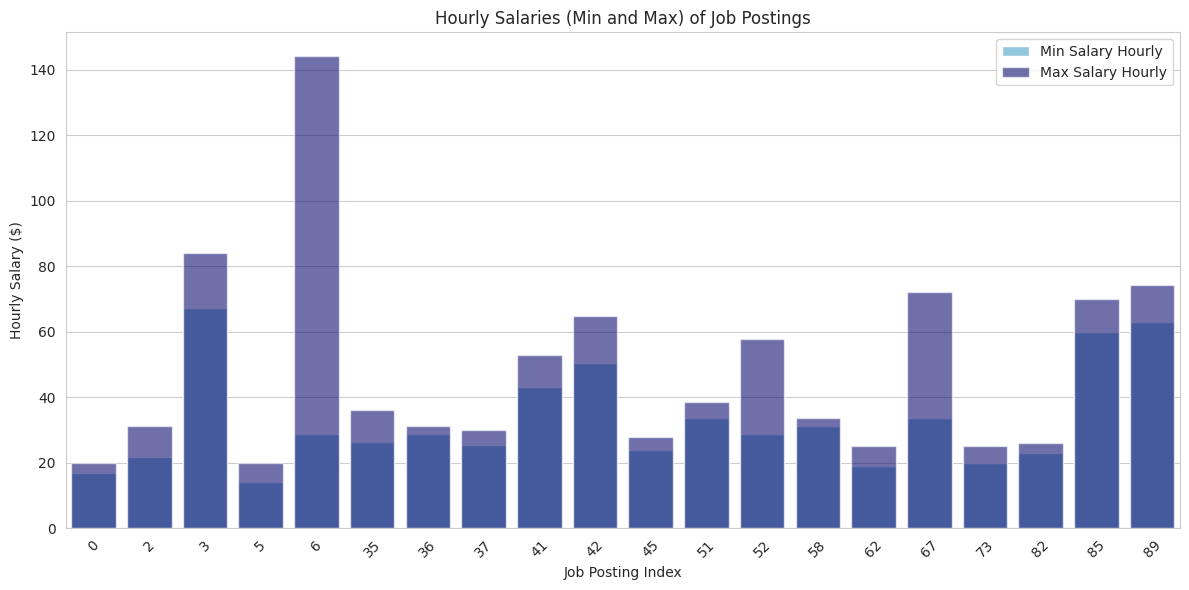

In [33]:

# Set a style for the plots
sns.set_style('whitegrid')

# Plot the hourly salaries
plt.figure(figsize=(12, 6))
sns.barplot(data=job_posting_salaries_copy.head(20), x=job_posting_salaries_copy.index[:20], 
            y="min_salary_hourly", color="skyblue", label="Min Salary Hourly")
sns.barplot(data=job_posting_salaries_copy.head(20), x=job_posting_salaries_copy.index[:20], 
            y="max_salary_hourly", color="navy", alpha=0.6, label="Max Salary Hourly")

# Add labels and title
plt.xlabel("Job Posting Index")
plt.ylabel("Hourly Salary ($)")
plt.title("Hourly Salaries (Min and Max) of Job Postings")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


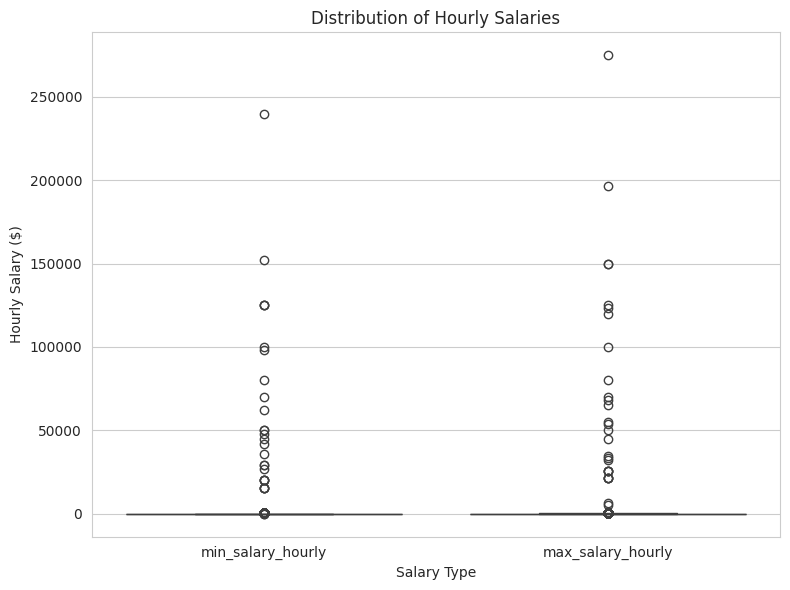

In [34]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=job_posting_salaries_copy[['min_salary_hourly', 'max_salary_hourly']])
plt.title("Distribution of Hourly Salaries")
plt.ylabel("Hourly Salary ($)")
plt.xlabel("Salary Type")
plt.tight_layout()
plt.show()


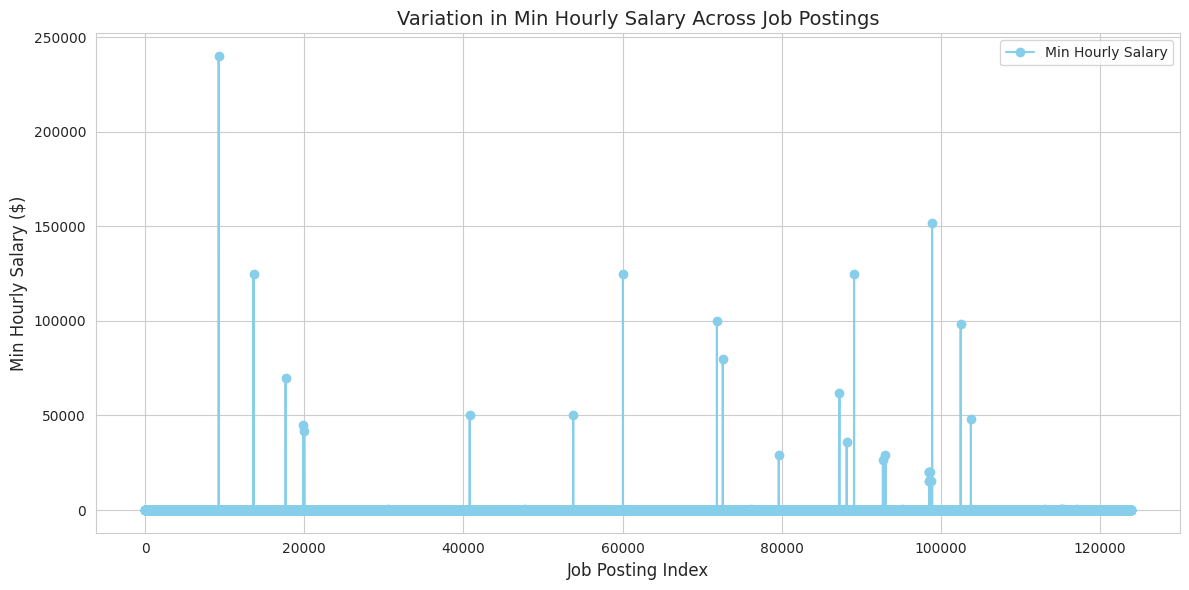

In [35]:

# Plot min_salary_hourly
plt.figure(figsize=(12, 6))
plt.plot(job_posting_salaries_copy['min_salary_hourly'], marker='o', linestyle='-', color='skyblue', label="Min Hourly Salary")

# Add titles and labels
plt.title("Variation in Min Hourly Salary Across Job Postings", fontsize=14)
plt.xlabel("Job Posting Index", fontsize=12)
plt.ylabel("Min Hourly Salary ($)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [36]:

# Calculate Z-scores for 'min_salary_hourly' and 'max_salary_hourly'
job_posting_salaries_copy['z_min'] = zscore(job_posting_salaries_copy['min_salary_hourly'])
job_posting_salaries_copy['z_max'] = zscore(job_posting_salaries_copy['max_salary_hourly'])

# Identify rows with Z-scores greater than 3 or less than -3 (outliers)
outliers_min = job_posting_salaries_copy[job_posting_salaries_copy['z_min'].abs() > 3]
outliers_max = job_posting_salaries_copy[job_posting_salaries_copy['z_max'].abs() > 3]

# Combine the outliers from both 'min_salary_hourly' and 'max_salary_hourly'
outliers = pd.concat([outliers_min, outliers_max])

# Print the values that are being removed
print("Removed outliers:")
print(outliers[['min_salary_hourly', 'max_salary_hourly', 'z_min', 'z_max']])

# Filter out rows with Z-scores greater than 3 (considered outliers)
job_posting_salaries_copy = job_posting_salaries_copy[
    (job_posting_salaries_copy['z_min'].abs() <= 3) &
    (job_posting_salaries_copy['z_max'].abs() <= 3)
]

# Display the data after removing outliers
print("\nData after removing outliers:")
print(job_posting_salaries_copy[['min_salary_hourly', 'max_salary_hourly']].describe())


Removed outliers:
        min_salary_hourly  max_salary_hourly      z_min      z_max
9237             240000.0           275000.0  96.634064  93.342504
13614            125000.0           150000.0  50.311154  50.894600
17646             70000.0            80000.0  28.156719  27.123773
19869             45000.0            50000.0  18.086521  16.936276
19991             42000.0            45000.0  16.878098  15.238360
40781             50000.0            70000.0  20.100561  23.727941
53787             50000.0            65000.0  20.100561  22.030025
60038            125000.0           125000.0  50.311154  42.405019
71845            100000.0           120000.0  40.240957  40.707103
72585             80000.0           100000.0  32.184798  33.915438
79620             29120.0            32240.0  11.689932  10.905278
87241             62000.0            68000.0  24.934256  23.048774
88153             36000.0            54000.0  14.461250  18.294609
89082            125000.0           150000.0

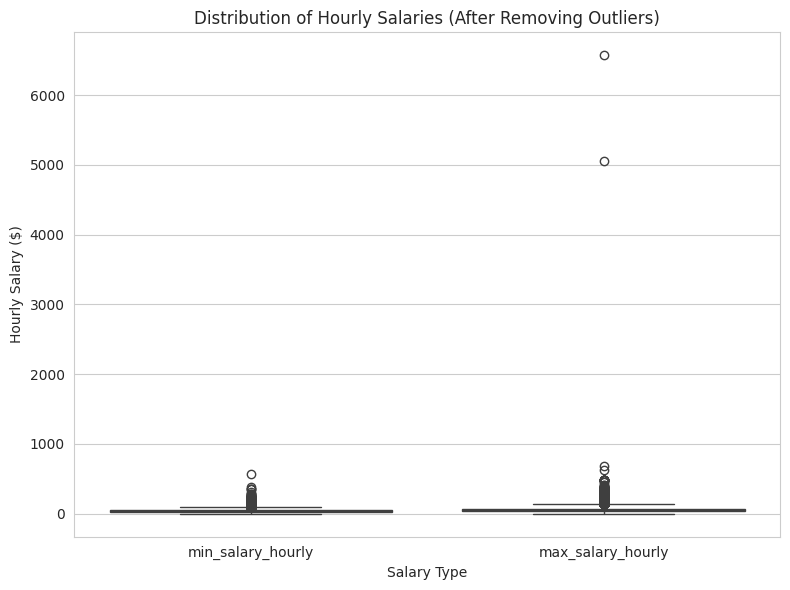

In [37]:
# Plot the boxplot after removing outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=job_posting_salaries_copy[['min_salary_hourly', 'max_salary_hourly']])
plt.title("Distribution of Hourly Salaries (After Removing Outliers)")
plt.ylabel("Hourly Salary ($)")
plt.xlabel("Salary Type")
plt.tight_layout()
plt.show()


In [38]:
# Sort the DataFrame by 'max_salary_hourly' in descending order
top_max_salary = job_posting_salaries_copy.sort_values(by='max_salary_hourly', ascending=False).head(5)

# Print the top 5 rows ordered by 'max_salary_hourly'
print("Top 5 rows with highest max_salary_hourly:")
print(top_max_salary[['min_salary_hourly', 'max_salary_hourly']])


Top 5 rows with highest max_salary_hourly:
       min_salary_hourly  max_salary_hourly
40101          65.000000        6570.000000
48226          50.000000        5060.000000
47712         562.500000         687.500000
30476         375.000000         625.000000
73491         240.384615         480.769231


In [46]:
# Stage 2: Further remove outliers using IQR
# Calculate the first (Q1) and third (Q3) quartiles for both salary columns
Q1_min = job_posting_salaries_copy['min_salary_hourly'].quantile(0.25)
Q3_min = job_posting_salaries_copy['min_salary_hourly'].quantile(0.75)
IQR_min = Q3_min - Q1_min

Q1_max = job_posting_salaries_copy['max_salary_hourly'].quantile(0.25)
Q3_max = job_posting_salaries_copy['max_salary_hourly'].quantile(0.75)
IQR_max = Q3_max - Q1_max

# Define bounds using IQR
lower_bound_min = Q1_min - 1.5 * IQR_min
upper_bound_min = Q3_min + 1.5 * IQR_min

lower_bound_max = Q1_max - 1.5 * IQR_max
upper_bound_max = Q3_max + 1.5 * IQR_max

# Debugging: Print calculated IQR bounds
print("\nIQR Bounds for min_salary_hourly:")
print(f"Lower Bound: {lower_bound_min}, Upper Bound: {upper_bound_min}")
print("\nIQR Bounds for max_salary_hourly:")
print(f"Lower Bound: {lower_bound_max}, Upper Bound: {upper_bound_max}")

# Apply IQR filtering
job_posting_salaries_copy = job_posting_salaries_copy[
    (job_posting_salaries_copy['min_salary_hourly'] >= lower_bound_min) &
    (job_posting_salaries_copy['min_salary_hourly'] <= upper_bound_min) &
    (job_posting_salaries_copy['max_salary_hourly'] >= lower_bound_max) &
    (job_posting_salaries_copy['max_salary_hourly'] <= upper_bound_max)
]

# Stage 3: Manually cap extreme max_salary_hourly outliers
max_salary_cap = 110  # Manually defined cap to remove extreme max salaries.
min_salary_cap = 80  # Manually defined cap to remove extreme max salaries.

max_salary_low = 20
min_salary_low = 7.25

job_posting_salaries_copy = job_posting_salaries_copy[
    (job_posting_salaries_copy['max_salary_hourly'] <= max_salary_cap)
]
job_posting_salaries_copy = job_posting_salaries_copy[
    (job_posting_salaries_copy['max_salary_hourly'] >= max_salary_low)
]

job_posting_salaries_copy = job_posting_salaries_copy[
    (job_posting_salaries_copy['min_salary_hourly'] <= min_salary_cap)
]
job_posting_salaries_copy = job_posting_salaries_copy[
    (job_posting_salaries_copy['min_salary_hourly'] >= min_salary_low)
]


# Display final statistics after all filtering
print("\nData after applying Z-score, IQR, and manual cap:")
print(job_posting_salaries_copy[['min_salary_hourly', 'max_salary_hourly']].describe())



IQR Bounds for min_salary_hourly:
Lower Bound: -10.32725961538462, Upper Bound: 84.5454326923077

IQR Bounds for max_salary_hourly:
Lower Bound: -16.826923076923073, Upper Bound: 117.78846153846153

Data after applying Z-score, IQR, and manual cap:
       min_salary_hourly  max_salary_hourly
count       24887.000000       24887.000000
mean           38.623559          51.590093
std            15.819363          21.776323
min             7.307692          20.000000
25%            25.250000          33.653846
50%            36.057692          48.076923
75%            48.968173          67.307692
max            80.000000         110.000000


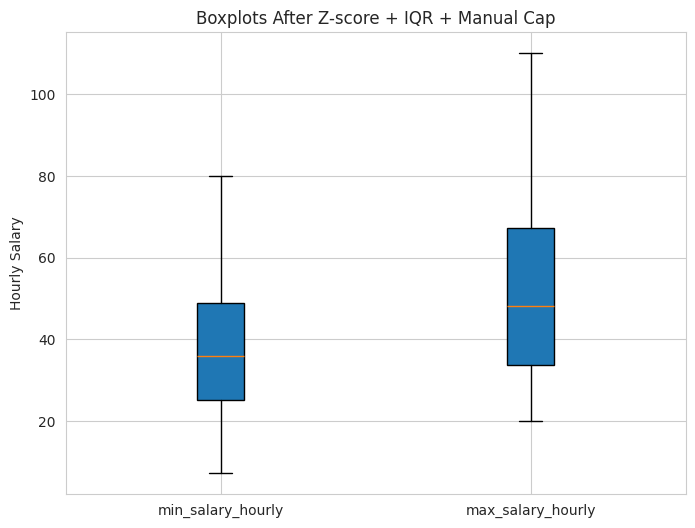

In [47]:
# Visualization to confirm no outliers remain
plt.figure(figsize=(8, 6))
plt.boxplot(
    [job_posting_salaries_copy['min_salary_hourly'], job_posting_salaries_copy['max_salary_hourly']],
    vert=True,
    patch_artist=True,
    tick_labels=['min_salary_hourly', 'max_salary_hourly']  # Updated parameter name
)
plt.title('Boxplots After Z-score + IQR + Manual Cap')
plt.ylabel('Hourly Salary')
plt.show()




In [48]:
# Check variability for applies and views
variability = job_posting[['applies', 'views']].std()
print("\nColumn Variability:\n", variability)



Column Variability:
 applies    28.847838
views      86.236403
dtype: float64


In [49]:

# Select Features
columns_to_process = ['views', 'applies']
features = job_posting[columns_to_process].copy()

# Step 1: Handle Missing Values
for col in features.columns:
    features[col] = features[col].fillna(features[col].median())

# Step 2: Remove Outliers Using Z-Score
zscore_threshold = 3
for col in features.columns:
    features = features[(np.abs(zscore(features[col])) < zscore_threshold)]

# Step 3: Handle Skewness (Log Transformation)
for col in features.columns:
    if (features[col] > 0).all():  # Ensure no zero or negative values
        features[col] = np.log1p(features[col])


In [50]:

# Step 4: Recalculate Skewness
skewness_values = features.apply(lambda x: skew(x, nan_policy='omit'))
print("\nSkewness After Transformations:\n", skewness_values)



Skewness After Transformations:
 views      1.448230
applies    1.543705
dtype: float64


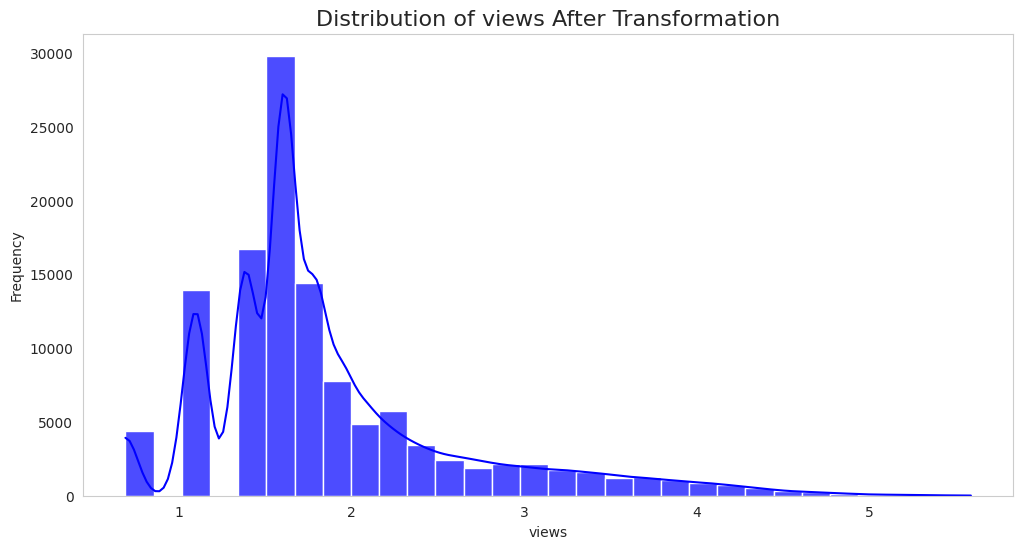

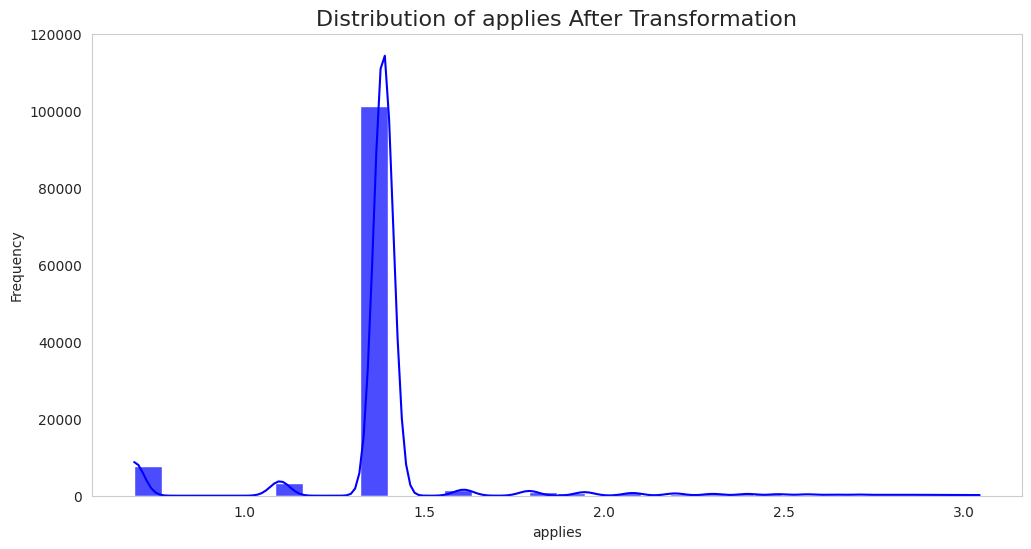

In [51]:

# Step 5: Visualize Distributions
for col in features.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(features[col], kde=True, bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribution of {col} After Transformation', fontsize=16)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()





Skewness After Square Root Transformation and Winsorization:
 views      0.791284
applies   -0.154936
dtype: float64


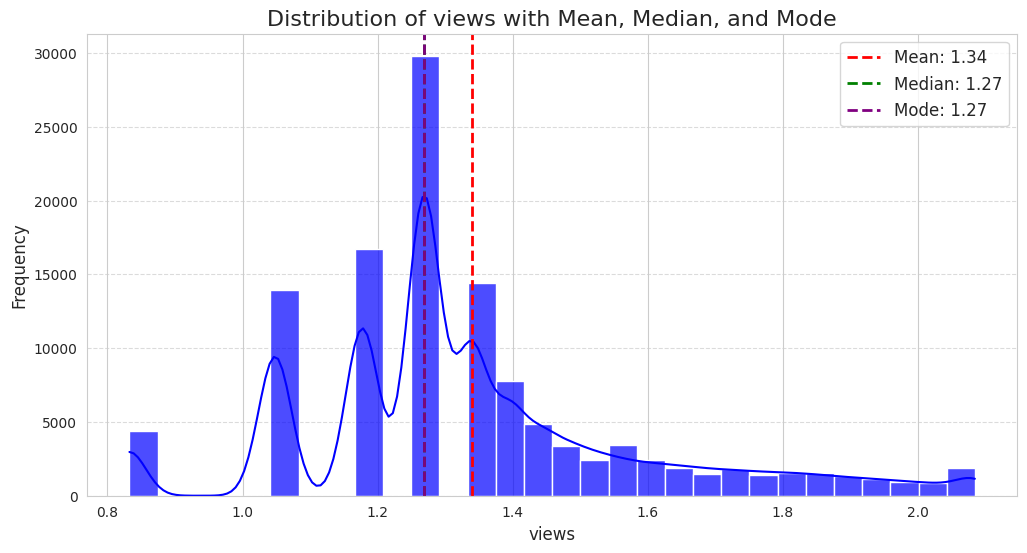

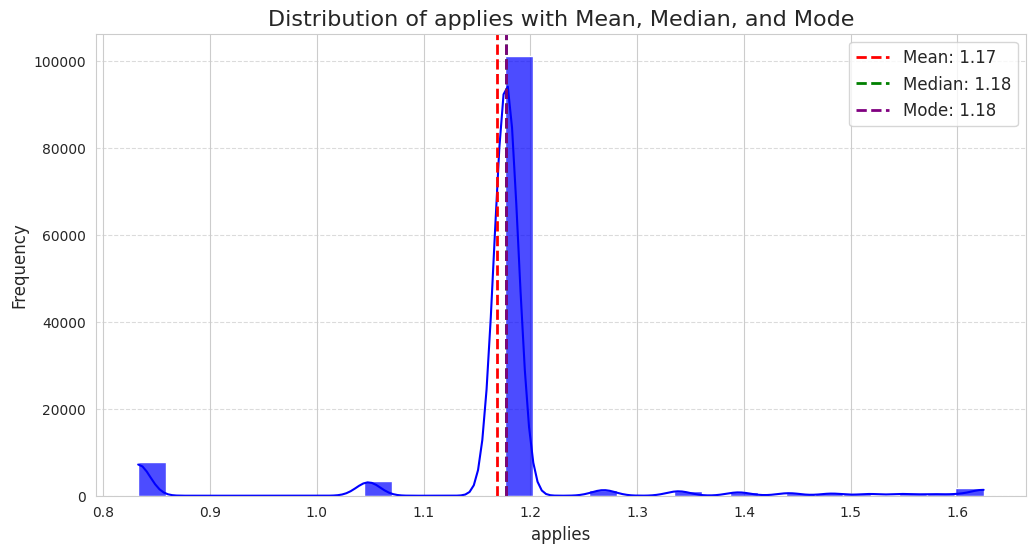

In [52]:
# Step 1: Square Root Transformation
for col in features.columns:
    features[col] = np.sqrt(features[col])

# Step 2: Winsorization (Cap Extreme Values)
for col in features.columns:
    lower_limit = features[col].quantile(0.01)
    upper_limit = features[col].quantile(0.99)
    features[col] = features[col].clip(lower=lower_limit, upper=upper_limit)

# Step 3: Recalculate Skewness
skewness_values_after = features.apply(lambda x: skew(x, nan_policy='omit'))
print("\nSkewness After Square Root Transformation and Winsorization:\n", skewness_values_after)


# Step 4: Visualize Results with Mean, Median, and Mode
for col in features.columns:
    plt.figure(figsize=(12, 6))
    
    # Calculate statistics
    mean = features[col].mean()
    median = features[col].median()
    mode = features[col].mode()[0]  # Get the first mode in case of multiple modes
    
    # Plot histogram
    sns.histplot(features[col], kde=True, bins=30, color='blue', alpha=0.7)
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
    plt.axvline(mode, color='purple', linestyle='dashed', linewidth=2, label=f'Mode: {mode:.2f}')
    
    # Titles and labels
    plt.title(f'Distribution of {col} with Mean, Median, and Mode', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


